In [1]:
# import packages
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from importlib import reload

sys.path.append('../')

# custom
from utils.GetFileNames import get_file_names
import utils.Metrics as Metrics
import utils.Preprocessing as Preprocessing

Processing: 490-ref-ISU_073-rep_1-W - JL.png (1/4)


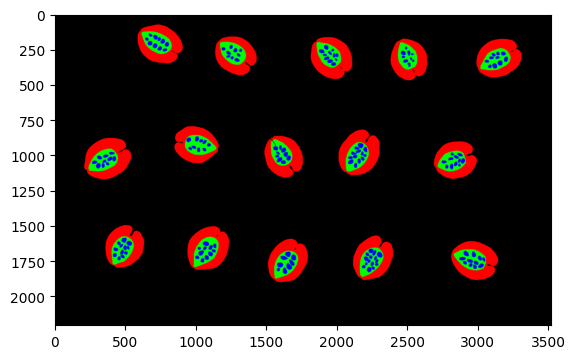

Processing: BILL_490-ref-ISU_073-rep_1-W.png (2/4)


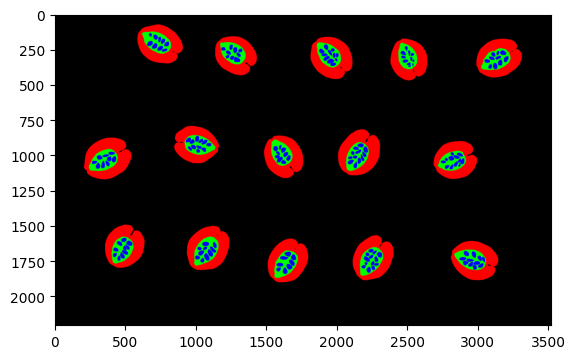

Processing: pete_490-ref-ISU_073-rep_1-W.png (3/4)


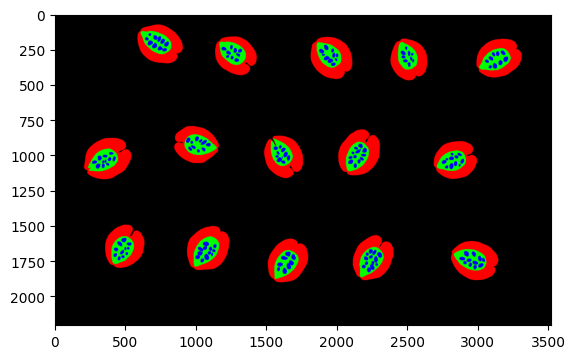

Processing: pred_490-ref-ISU_073-rep_1-W.png (4/4)


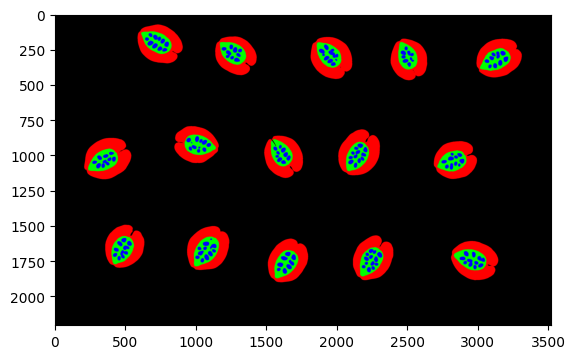

In [6]:
# load data + files
data_path = "../data/human_eval/"

# gather image names
image_names = get_file_names(data_path, ".png")

# load images
images = []
for i, name in enumerate(image_names):
    print(f"Processing: {name} ({i+1}/{len(image_names)})")
    img = Image.open(data_path + name)
    img = np.array(img).astype("uint8") / 255

    # remove artifacts
    img = Preprocessing.remove_artifacts(img)

    img[img.sum(axis=2) == 3] = 0
    plt.imshow(img)
    plt.show()
    
    images.append(img)

['490-ref-ISU_073-rep_1-W - JL.png',
 'BILL_490-ref-ISU_073-rep_1-W.png',
 'pete_490-ref-ISU_073-rep_1-W.png',
 'pred_490-ref-ISU_073-rep_1-W.png']

In [7]:
# extract surfaces
john_wing = images[0][:,:,0] == 1
john_env = images[0][:,:,1] == 1
john_seed = images[0][:,:,2] == 1

bill_wing = (images[1][:,:,0] == 1)
bill_env = (images[1][:,:,1] == 1)
bill_seed = (images[1][:,:,2] == 1)

pete_wing = images[2][:,:,0] == 1
pete_env = images[2][:,:,1] == 1
pete_seed = images[2][:,:,2] == 1

model_wing = images[3][:,:,0] == 1
model_env = images[3][:,:,1] == 1
model_seed = images[3][:,:,2] == 1

In [13]:
# model v. gt (baseline)
model_wing_iou = Metrics.iou(model_wing, pete_wing)
model_env_iou = Metrics.iou(model_env, pete_env)
model_seed_iou = Metrics.iou(model_seed, pete_seed)

# print
print(f"Model/Pete Wing IOU: {model_wing_iou:.2%}")
print(f"Model/Pete Env IOU: {model_env_iou:.2%}")
print(f"Model/Pete Seed IOU: {model_seed_iou:.2%}")

Model/Pete Wing IOU: 96.71%
Model/Pete Env IOU: 83.94%
Model/Pete Seed IOU: 74.15%


In [14]:
# model v. bill
m_bill_wing_iou = Metrics.iou(model_wing, bill_wing)
m_bill_env_iou = Metrics.iou(model_env, bill_env)
m_bill_seed_iou = Metrics.iou(model_seed, bill_seed)

# print
print(f"Model/Bill Wing IOU: {m_bill_wing_iou:.2%}")
print(f"Model/Bill Env IOU: {m_bill_env_iou:.2%}")
print(f"Model/Bill Seed IOU: {m_bill_seed_iou:.2%}")

Model/Bill Wing IOU: 95.57%
Model/Bill Env IOU: 79.56%
Model/Bill Seed IOU: 73.82%


In [15]:
# model v. john
# model v. bill
m_john_wing_iou = Metrics.iou(model_wing, john_wing)
m_john_env_iou = Metrics.iou(model_env, john_env)
m_john_seed_iou = Metrics.iou(model_seed, john_seed)

# print
print(f"Model/John Wing IOU: {m_john_wing_iou:.2%}")
print(f"Model/John Env IOU: {m_john_env_iou:.2%}")
print(f"Model/John Seed IOU: {m_john_seed_iou:.2%}")

Model/John Wing IOU: 94.26%
Model/John Env IOU: 83.83%
Model/John Seed IOU: 73.30%


In [25]:
# bill v. pete
bp_wing_iou = Metrics.iou(bill_wing, pete_wing)
bp_env_iou = Metrics.iou(bill_env, pete_env)
bp_seed_iou = Metrics.iou(bill_seed, pete_seed)

# print
print(f"Bill/Pete Wing IOU: {bp_wing_iou:.2%}")
print(f"Bill/Pete Env IOU: {bp_env_iou:.2%}")
print(f"Bill/Pete Seed IOU: {bp_seed_iou:.2%}")

Bill/Pete Wing IOU: 95.33%
Bill/Pete Env IOU: 75.53%
Bill/Pete Seed IOU: 66.97%


In [27]:
# bill v john
bj_wing_iou = Metrics.iou(bill_wing, john_wing)
bj_env_iou = Metrics.iou(bill_env, john_env)
bj_seed_iou = Metrics.iou(bill_seed, john_seed)

# print
print(f"Bill/John Wing IOU: {bj_wing_iou:.2%}")
print(f"Bill/John Env IOU: {bj_env_iou:.2%}")
print(f"Bill/John Seed IOU: {bj_seed_iou:.2%}")

Bill/John Wing IOU: 92.10%
Bill/John Env IOU: 79.95%
Bill/John Seed IOU: 66.35%


In [28]:
# john v. pete
# bill v john
pj_wing_iou = Metrics.iou(pete_wing, john_wing)
pj_env_iou = Metrics.iou(pete_env, john_env)
pj_seed_iou = Metrics.iou(pete_seed, john_seed)

# print
print(f"Pete/John Wing IOU: {pj_wing_iou:.2%}")
print(f"Pete/John Env IOU: {pj_env_iou:.2%}")
print(f"Pete/John Seed IOU: {pj_seed_iou:.2%}")

Pete/John Wing IOU: 92.81%
Pete/John Env IOU: 80.30%
Pete/John Seed IOU: 69.70%


In [29]:
avg_wing = (model_wing_iou + m_bill_wing_iou + m_john_wing_iou) / 3.0
avg_env = (model_env_iou + m_bill_env_iou + m_john_env_iou) / 3.0
avg_seed = (model_seed_iou + m_bill_seed_iou + m_john_seed_iou) / 3.0

print(f"Average Model v. Human Wing IoU: {avg_wing:.2%}")
print(f"Average Model v. Human Env IoU: {avg_env:.2%}")
print(f"Average Model v. Human Seed IoU: {avg_seed:.2%}")

Average Model v. Human Wing IoU: 95.51%
Average Model v. Human Env IoU: 82.44%
Average Model v. Human Seed IoU: 73.76%


In [30]:
human_wing = (bp_wing_iou + bj_wing_iou + pj_wing_iou) / 3.0
human_env = (bp_env_iou + bj_env_iou + pj_env_iou) / 3.0
human_seed = (bp_seed_iou + bj_seed_iou + pj_seed_iou) / 3.0

print(f"Average Human v. Human Wing IoU: {human_wing:.2%}")
print(f"Average Human v. Human Env IoU: {human_env:.2%}")
print(f"Average Human v. Human Seed IoU: {human_seed:.2%}")

Average Human v. Human Wing IoU: 93.41%
Average Human v. Human Env IoU: 78.59%
Average Human v. Human Seed IoU: 67.67%
